In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

In [19]:
df = pd.read_csv("m_sand_concrete_dataset.csv")

In [20]:
df = df.copy()
iso = IsolationForest(contamination=0.1, random_state=42)

X_features = df.drop(columns=["Compressive_strength", "CPC"])
outlier_pred = iso.fit_predict(X_features)

df_clean = df[outlier_pred == 1].reset_index(drop=True)
print("Shape original:", df.shape)
print("Shape after remove outlier:", df_clean.shape)

Shape original: (86, 8)
Shape after remove outlier: (77, 8)


In [21]:
X = df_clean.iloc[:, :6].values   # feature
y = df_clean.iloc[:, 6:].values   # label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)

gpr_base = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", GaussianProcessRegressor(kernel=kernel,
                                     n_restarts_optimizer=10,
                                     random_state=42))
])
# gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
multi_gpr = MultiOutputRegressor(gpr_base)

In [23]:
multi_gpr.fit(X_train, y_train)
multi_gpr

,estimator,Pipeline(step...m_state=42))])
,n_jobs,None
,copy,True
,with_mean,True
,with_std,True
,kernel,1**2 * RBF(le...noise_level=1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,False
,copy_X_train,True


In [24]:
def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse
    
y_pred_train = multi_gpr.predict(X_train)
y_pred_test = multi_gpr.predict(X_test)

# CS
r2_cs_train, rmse_cs_train = calc_metrics(y_train[:,0], y_pred_train[:,0])
r2_cs_test,  rmse_cs_test  = calc_metrics(y_test[:,0],  y_pred_test[:,0])

# CPC
r2_cpc_train, rmse_cpc_train = calc_metrics(y_train[:,1], y_pred_train[:,1])
r2_cpc_test,  rmse_cpc_test  = calc_metrics(y_test[:,1],  y_pred_test[:,1])

print("Train:")
print(f"CS  - R²: {r2_cs_train:.3f}, RMSE: {rmse_cs_train:.3f}")
print(f"CPC - R²: {r2_cpc_train:.3f}, RMSE: {rmse_cpc_train:.3f}")

print("Test:")
print(f"CS  - R²: {r2_cs_test:.3f}, RMSE: {rmse_cs_test:.3f}")
print(f"CPC - R²: {r2_cpc_test:.3f}, RMSE: {rmse_cpc_test:.3f}")

Train:
CS  - R²: 0.902, RMSE: 4.775
CPC - R²: 0.894, RMSE: 2.741
Test:
CS  - R²: 0.931, RMSE: 5.818
CPC - R²: 0.845, RMSE: 3.431


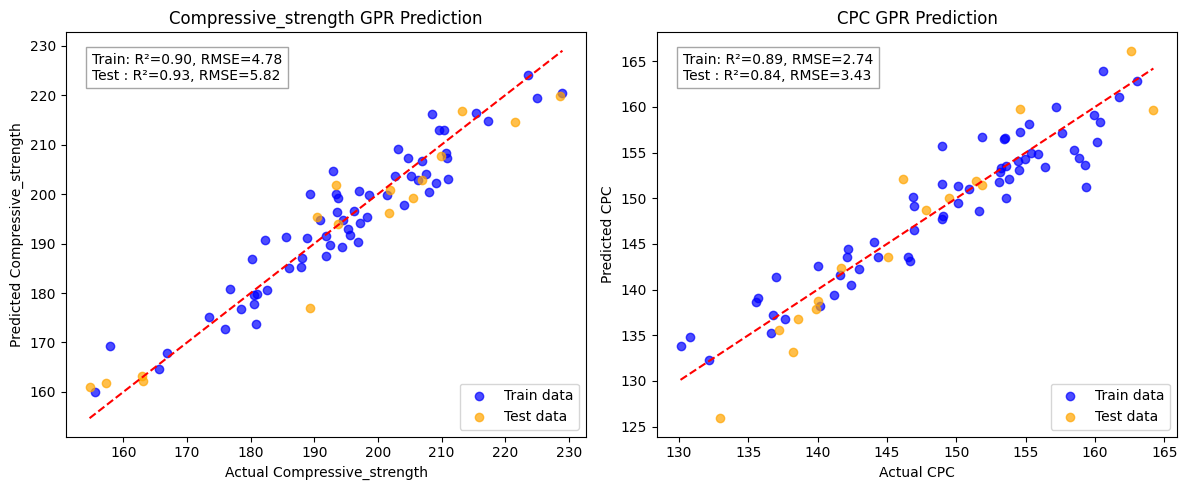

In [27]:
plt.figure(figsize=(12,5))
model_name = "GPR"

# Compressive Strength
plt.subplot(1,2,1)
plt.scatter(y_train[:,0], y_pred_train[:,0], alpha=0.7, color="blue", label="Train data")
plt.scatter(y_test[:,0], y_pred_test[:,0], alpha=0.7, color="orange", label="Test data")
plt.plot([min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         [min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())], 'r--')
plt.text(0.05, 0.95,
         f"Train: R²={r2_cs_train:.2f}, RMSE={rmse_cs_train:.2f}\n"
         f"Test : R²={r2_cs_test:.2f}, RMSE={rmse_cs_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual Compressive_strength")
plt.ylabel("Predicted Compressive_strength")
plt.title(f"Compressive_strength {model_name} Prediction")
plt.legend()

# CPC
plt.subplot(1,2,2)
plt.scatter(y_train[:,1], y_pred_train[:,1], alpha=0.7, color="blue", label="Train data")
plt.scatter(y_test[:,1], y_pred_test[:,1], alpha=0.7, color="orange", label="Test data")
plt.plot([min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         [min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())], 'r--')
plt.text(0.05, 0.95,
         f"Train: R²={r2_cpc_train:.2f}, RMSE={rmse_cpc_train:.2f}\n"
         f"Test : R²={r2_cpc_test:.2f}, RMSE={rmse_cpc_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual CPC")
plt.ylabel("Predicted CPC")
plt.title(f"CPC {model_name} Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
import pickle
with open("best_GPR_model.pkl", "wb") as f:
    pickle.dump(multi_gpr, f)

# with open("best_xgb_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)